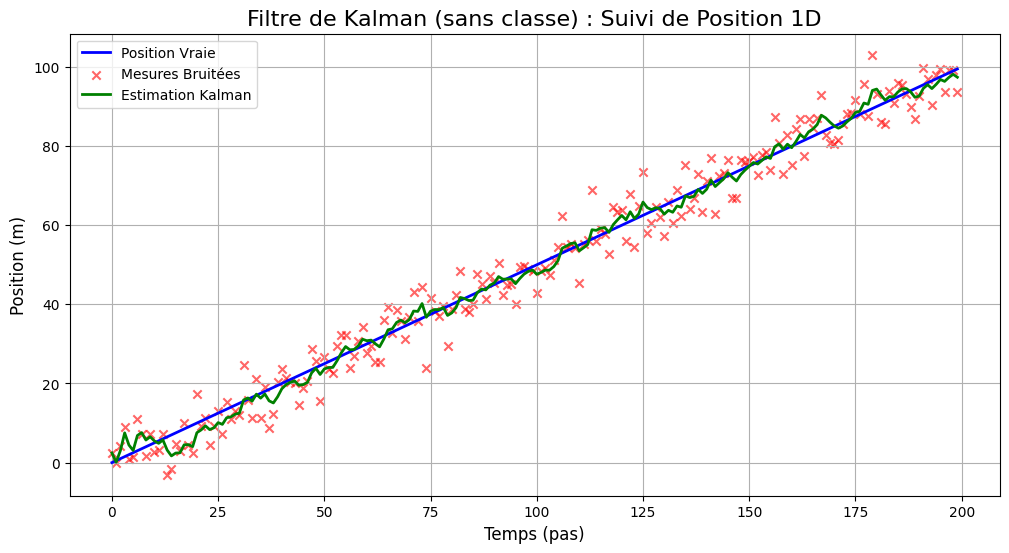

Comparaison Quantitative des Erreurs :

                       |   MAE    |   RMSE
-----------------------|----------|----------
Mesures Brutes         |   3.70   |   4.65  
Estimation Kalman      |   1.54   |   1.95  


In [70]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Partie 1 : Simulation de données
# -------------------------------------------------------------------
np.random.seed(42)
n_steps = 200
dt = 1.0  # Temps entre chaque mesure

# Préenregistrement des données réelles
true_velocity = (100 / (n_steps * dt)) #100m en n_steps
true_position = np.zeros(n_steps)
for i in range(1, n_steps):
    true_position[i] = true_position[i-1] + true_velocity * dt

# Bruitage des données
measurement_noise_std = 5.0
measurements = true_position + np.random.normal(0, measurement_noise_std, n_steps) #On suppose avoir un bruit parfait

# -------------------------------------------------------------------
# Partie 2 : Initialisaiton du filtre
# -------------------------------------------------------------------
# X regroupe tout ce qu'on souhaite estimer
# x = [[position],[vitesse ]]
x = np.array([0.0, 0.0])

# P représente la matrice de covariance de l'incertitude. C'est la confiance dans l'estimation de l'état, qui est initialement faible.
P = np.eye(2) * 500  # Matrice 2x2 avec une grande incertitude initiale

# F décrit le modèle physique, c'est à dire comment l'état est censé évaluer au cours du temps.
# nouvelle_position = ancienne_pos + ancienne_vitesse * dt
# nouvelle_vitesse = ancienne, car vitesse constante
F = np.array([[1, dt],
              [0, 1]])

# La matrice H relie l'état inconnu à la mesure connue. Ici on ne mesure que la vitesse
H = np.array([[1, 0]])

#R est la covariance du bruit de mesure. C'est l'incertitude capteur donnée par le fabriquant
R = np.array([[measurement_noise_std**2]])

# Q est la covariance du processus. L'incertitude de notre modèle.
Q = np.array([[1, 0.0],
              [0.0, 0.01]])


# Liste pour stocker les résultats de l'estimation de position
estimates = []

# -------------------------------------------------------------------
# Boucle de Kalman
# -------------------------------------------------------------------
for z in measurements:
    # PREDICTION
    x_pred = F @ x
    P_pred = F @ P @ F.T + Q

    # correction
    y = z - (H @ x_pred)
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)
    x = x_pred + (K @ y)
    P = (np.eye(2) - K @ H) @ P_pred
    # On ne stocke que la position (le premier élément du vecteur d'état x) pour l'affichage.
    estimates.append(x[0])

# -------------------------------------------------------------------
# aFFICHAGE
# -------------------------------------------------------------------
plt.figure(figsize=(12, 6))
plt.plot(range(n_steps), true_position, 'b-', label='Position Vraie', linewidth=2)
plt.scatter(range(n_steps), measurements, marker='x', color='r', alpha=0.6, label='Mesures Bruitées')
plt.plot(range(n_steps), estimates, 'g-', label='Estimation Kalman', linewidth=2)
plt.title("Filtre de Kalman (sans classe) : Suivi de Position 1D", fontsize=16)
plt.xlabel("Temps (pas)", fontsize=12)
plt.ylabel("Position (m)", fontsize=12)
plt.legend()
plt.grid(True)
plt.show()




# Calcul des erreurs
error_measurements = measurements - true_position
error_kalman = np.array(estimates) - true_position
# (MAE et RMSE)
# Pour les mesures brutes
mae_measurements = np.mean(np.abs(error_measurements))
rmse_measurements = np.sqrt(np.mean(error_measurements**2))
# Pour l'estimation de Kalman
mae_kalman = np.mean(np.abs(error_kalman))
rmse_kalman = np.sqrt(np.mean(error_kalman**2))


# --- Affichage comparatif ---

print("Comparaison Quantitative des Erreurs :\n")
print(f"                       |   MAE    |   RMSE")
print("-----------------------|----------|----------")
print(f"Mesures Brutes         | {mae_measurements:^8.2f} | {rmse_measurements:^8.2f}")
print(f"Estimation Kalman      | {mae_kalman:^8.2f} | {rmse_kalman:^8.2f}")

Comparaison Quantitative des Erreurs (distance euclidienne moyenne) :

                       |   MAE    |   RMSE
-----------------------|----------|----------
Mesures Brutes (GPS)   |   3.14   |   3.51  
Estimation Kalman      |   1.52   |   1.69  


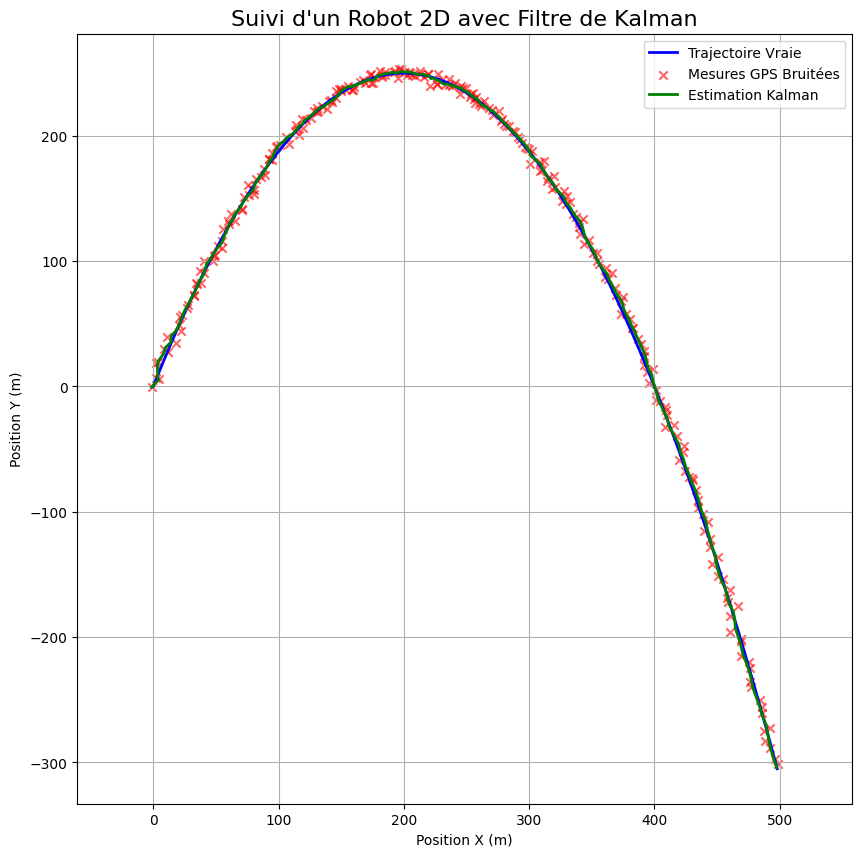

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# -------------------------------------------------------------------
# Partie 1 : Simulation de données
# -------------------------------------------------------------------
dt = 1.0
n_steps = 250
# Commande : on applique une accélération constante vers le bas ("gravité")
u_command = np.array([0.0, -0.05])
u_list = np.tile(u_command, (n_steps, 1))

# Initialisation des variables pour la simulation de la vérité terrain
x_true = np.zeros((4, n_steps))

# On donne une vitesse initiale pour créer l'arc.
initial_velocity = np.array([2.0, 5.0])
x_true[2:, 0] = initial_velocity

# Matrices F et B pour la simulation
F_sim = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
B_sim = np.array([[0.5*dt**2, 0], [0, 0.5*dt**2], [dt, 0], [0, dt]])

# Boucle de simulation de la trajectoire vraie
for t in range(1, n_steps):
    x_true[:, t] = F_sim @ x_true[:, t-1] + B_sim @ u_list[t-1]

# Simulation des mesures GPS bruitées
noise_std = 2.5
measurements = x_true[:2, :] + np.random.normal(0, noise_std, (2, n_steps))


# -------------------------------------------------------------------
# Boucle de Kalman
# -------------------------------------------------------------------
x_est = np.array([0.0, 0.0, 0.0, 0.0])
P = np.eye(4) * 500
F = np.array([[1, 0, dt, 0], [0, 1, 0, dt], [0, 0, 1, 0], [0, 0, 0, 1]])
B = np.array([[0.5*dt**2, 0], [0, 0.5*dt**2], [dt, 0], [0, dt]])
H = np.array([[1, 0, 0, 0], [0, 1, 0, 0]])
R = np.eye(2) * noise_std**2
q_val = 0.01
Q = np.array([
    [0.25*dt**4, 0, 0.5*dt**3, 0],
    [0, 0.25*dt**4, 0, 0.5*dt**3],
    [0.5*dt**3, 0, dt**2, 0],
    [0, 0.5*dt**3, 0, dt**2]
]) * q_val

estimates = []

# -------------------------------------------------------------------
# 3. Boucle Principale du Filtre
# -------------------------------------------------------------------
for t in range(n_steps):
    u = u_list[t-1] if t > 0 else np.array([0,0])
    x_pred = F @ x_est + B @ u
    P_pred = F @ P @ F.T + Q

    z = measurements[:, t]
    y = z - H @ x_pred
    S = H @ P_pred @ H.T + R
    K = P_pred @ H.T @ np.linalg.inv(S)

    x_est = x_pred + K @ y
    P = (np.eye(4) - K @ H) @ P_pred

    estimates.append(x_est[:2])

estimates = np.array(estimates)

# -------------------------------------------------------------------
# Résultats
# -------------------------------------------------------------------
plt.figure(figsize=(10, 10))
plt.plot(x_true[0, :], x_true[1, :], 'b-', label='Trajectoire Vraie', linewidth=2)
plt.scatter(measurements[0, :], measurements[1, :], c='r', marker='x', alpha=0.6, label='Mesures GPS Bruitées')
plt.plot(estimates[:, 0], estimates[:, 1], 'g-', label='Estimation Kalman', linewidth=2)

plt.title('Suivi d\'un Robot 2D avec Filtre de Kalman', fontsize=16)
plt.xlabel('Position X (m)')
plt.ylabel('Position Y (m)')
plt.legend()
plt.grid(True)
plt.axis('equal')

# -------------------------------------------------------------------
# Etude qualitative
# -------------------------------------------------------------------
# Calcul des vecteurs d'erreur pour chaque point dans le temps
error_measurements_vec = measurements - x_true[:2, :]
error_kalman_vec = estimates.T - x_true[:2, :]

# Calcul de la distance d'erreur (norme euclidienne) pour chaque point
error_measurements_dist = np.linalg.norm(error_measurements_vec, axis=0)
error_kalman_dist = np.linalg.norm(error_kalman_vec, axis=0)

# Calcul des métriques MAE et RMSE
mae_measurements = np.mean(error_measurements_dist)
rmse_measurements = np.sqrt(np.mean(error_measurements_dist**2))

mae_kalman = np.mean(error_kalman_dist)
rmse_kalman = np.sqrt(np.mean(error_kalman_dist**2))

# Affichage des résultats dans la console
print("Comparaison Quantitative des Erreurs (distance euclidienne moyenne) :\n")
print(f"                       |   MAE    |   RMSE")
print("-----------------------|----------|----------")
print(f"Mesures Brutes (GPS)   | {mae_measurements:^8.2f} | {rmse_measurements:^8.2f}")
print(f"Estimation Kalman      | {mae_kalman:^8.2f} | {rmse_kalman:^8.2f}")


# Affichage final du graphique
plt.show()